In [10]:
import pandas as pd
import seaborn as sns

train_df = pd.read_csv('train.csv')
building = pd.read_csv('building_metadata.csv')
weather_train = pd.read_csv('weather_train.csv')

In [14]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'])

KeyboardInterrupt: 

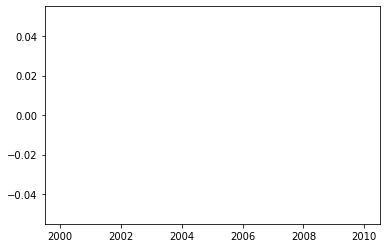

In [17]:
import matplotlib.pyplot as plt
#sns.kdeplot(data=train_df,x='meter_reading')
sns.lineplot(data=train_df,x='timestamp',y='meter_reading')

In [ ]:
train_df.shape

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
building['primary_use']=le.fit_transform(building['primary_use'])
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


In [5]:
building['primary_use'].unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

In [4]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
